In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [0]:
import warnings
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten,Dropout
from keras.optimizers import SGD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler

%matplotlib inline
warnings.filterwarnings("ignore")

# Set seeds to make the experiment more reproducible.
from tensorflow.compat.v1.random import set_random_seed
from numpy.random import seed
set_random_seed(1)
seed(1)

In [0]:
# multi headed multi-step cnn for the power usage dataset
import tensorflow as tf
from math import sqrt
from numpy import split
from numpy import mean
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate

In [0]:
df = pd.read_csv('/content/sample_data/climate_data2.csv',sep = ';')
df.head()
df.columns

Index(['# Date', 'UT time', 'Temperature', 'Relative Humidity', 'Pressure',
       'Wind speed', 'Wind direction', 'Rainfall', 'Snowfall', 'Snow depth',
       'Short-wave irradiation'],
      dtype='object')

In [0]:
dataset = pd.read_csv('/content/sample_data/climate_data2.csv',sep = ';',infer_datetime_format=True,header = 0, parse_dates=['# Date'], index_col=['# Date'])
#dataset.head()
type(dataset.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [0]:
dataset = pd.read_csv('/content/sample_data/climate_data2.csv',sep = ';',infer_datetime_format=True,header = 0, parse_dates=['# Date'])
#dataset.head()
dataset['# Date'] = pd.to_datetime(dataset['# Date'])
dataset = dataset.set_index("# Date")
type(dataset.index)
dataset.head()

,UT time,Temperature,Relative Humidity,Pressure,Wind speed,Wind direction,Rainfall,Snowfall,Snow depth,Short-wave irradiation
# Date,,,,,,,,,,
1980-01-01,24:00,284.55,76.59,968.48,3.61,113.37,5.203010,0.4192,0.000396,2157.781
1980-01-02,24:00,284.81,56.53,971.38,1.07,62.33,0.140569,0.0000,0.000535,3758.814
1980-01-03,24:00,284.46,44.87,973.32,0.93,344.69,0.000000,0.0000,0.000280,4024.862
1980-01-04,24:00,285.08,37.16,974.53,0.26,317.64,0.000000,0.0000,0.000155,4109.105
1980-01-05,24:00,283.85,38.61,974.07,1.70,295.94,0.000000,0.0000,0.000071,4146.958


In [0]:
dataset.dtypes

UT time                    object
Temperature               float64
Relative Humidity         float64
Pressure                  float64
Wind speed                float64
Wind direction            float64
Rainfall                  float64
Snowfall                  float64
Snow depth                float64
Short-wave irradiation    float64
dtype: object

In [0]:
dataset = dataset[['Rainfall','Temperature','Relative Humidity','Pressure','Wind speed','Wind direction','Short-wave irradiation']]
dataset.head()

,Rainfall,Temperature,Relative Humidity,Pressure,Wind speed,Wind direction,Short-wave irradiation
# Date,,,,,,,
1980-01-01,5.203010,284.55,76.59,968.48,3.61,113.37,2157.781
1980-01-02,0.140569,284.81,56.53,971.38,1.07,62.33,3758.814
1980-01-03,0.000000,284.46,44.87,973.32,0.93,344.69,4024.862
1980-01-04,0.000000,285.08,37.16,974.53,0.26,317.64,4109.105
1980-01-05,0.000000,283.85,38.61,974.07,1.70,295.94,4146.958


In [0]:
dataset.shape

(14701, 7)

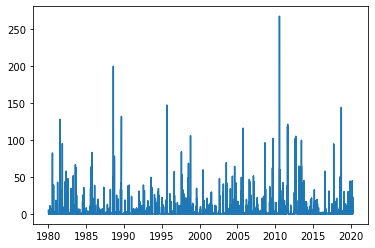

In [0]:
plt.plot(dataset['Rainfall'])
plt.show()

In [0]:
# split a univariate dataset into train/test sets
def split_dataset(data):
  # split into standard weeks
  train, test = data[:-1480], data[-1480:]
# restructure into windows of weekly data
#train = array(split(train, len(train)/7))
#test = array(split(test, len(test)/7))
  return train, test





In [0]:
train.shape

(5916, 7)

In [0]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
  scores = list()
  # calculate an RMSE score for each day
  # calculate mse
  mse = mean_squared_error(actual, predicted)
  # calculate rmse
  rmse = sqrt(mse)
  # store
  scores.append(rmse)
  # calculate overall RMSE
  #s = 0
  #for row in range(actual.shape[0]):
  #for col in range(actual.shape[1]):
  #s += (actual[row, col] - predicted[row, col])**2
  #score = sqrt(s / (actual.shape[0] * actual.shape[1]))
  return scores

# summarize scores
def summarize_scores(name, score, scores):
  s_scores = ', '.join(['%.1f' % s for s in scores])
  print('%s: [%.3f] %s' % (name, score, s_scores))
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=1):
  # flatten data
  data = train.copy()
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for _ in range(len(data)):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    # ensure we have enough data for this instance
    if out_end <= len(data):
      X.append(data[in_start:in_end, :])
      y.append(data[in_end:out_end, 0])
    # move along one time step
    in_start += 1
  return array(X), array(y)
# train the model
def build_model(train, n_input):
  # prepare data
  train_x, train_y = to_supervised(train, n_input)
  # define parameters
  verbose, epochs, batch_size = 0, 100, 8
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  # define model
  model = Sequential()
  model.add(Conv1D(32, 3, activation='relu', input_shape=(n_timesteps,n_features)))
  model.add(Conv1D(32, 3, activation='relu'))
  model.add(MaxPooling1D())
  model.add(Conv1D(16, 3, activation='relu'))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs))
  model.compile(loss='mse', optimizer='adam',metrics = ['accuracy'])
  # fit network
  model_history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
  return model,model_history
# make a forecast
def forecast(model, history, n_input):
  # flatten data
  data = array(history)
  #data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  # retrieve last observations for input data
  input_x = data[-n_input:, :]
  # reshape into [1, n_input, n]
  input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
  # forecast the next week
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat[0]
  return yhat
# evaluate a single model
def evaluate_model(train, test, n_input):
  # fit model
  model,model_history = build_model(train, n_input)
  # history is a list of weekly data
  history = [x for x in train]
  # walk-forward validation over each week
  predictions = list()
  for i in range(len(test)):
    # predict the week
    yhat_sequence = forecast(model, history, n_input)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
  # evaluate predictions days for each week
  predictions = array(predictions)
  scores = evaluate_forecasts(test[:,0], predictions)
  return scores,model_history

In [0]:
# load the new file
#dataset = read_csv('household_power_consumption_days.csv', header=0,
#infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 7
scores,model_history = evaluate_model(train, test, n_input)
# summarize scores
#summarize_scores('cnn', score, scores)
# plot scores
#days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
#pyplot.plot(days, scores, marker='o', label='cnn')
#pyplot.show()

KeyboardInterrupt: ignored

In [0]:
print(scores)

[8.07657252918383]


In [0]:
model_history.history

{'accuracy': [0.021820027,
  0.058525033,
  0.072733425,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'loss': [215.52297802148476,
  93.96402772897697,
  83.06804857517974,
  84.76928584485319,
  84.94495597590613,
  85.48685438336152,
  85.20915102103727,
  85.12729312021774,
  85.13299272726611,
  85.16105549349997,
  85.1596332040788,
  85.18132590441,
  85.17147994509247,
  85.17968667964973,
  85.10849403246168,
  85.17951186769547,
  85.203199535326,
  85.15836667804821,
  85.18224238825103,
  85.18530653737717,
  85.16408881024837,
  85.17752772150246,
  85.152

# *mutli-headed cnn model*

In [0]:
# split a univariate dataset into train/test sets
def split_dataset(data):
  scaler = StandardScaler()
  scaler.fit(data[:12573])
  #mean = data[:12573].mean(axis=0)
  #data -= mean
  #std = data[:22573].std(axis=0)
  #data /= std
  train, test= data[:-730], data[-730:]
  train = scaler.transform(train)
  test = scaler.transform(test)
  return train,test,scaler

# evaluate forecasts against expected values
def evaluate_forecasts(actual, predicted):
  scores = list()
  mse = mean_squared_error(actual, predicted)
  # calculate rmse
  rmse = sqrt(mse)
  # store
  scores.append(rmse)
  return scores

# summarize scores
#def summarize_scores(name, score, scores):
 # s_scores = ', '.join(['%.1f' % s for s in scores])
  #print('%s: [%.3f] %s' % (name, score, s_scores))
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=1):
  # flatten data
  data = train.copy()
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for _ in range(len(data)):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    # ensure we have enough data for this instance
    if out_end <= len(data):
      X.append(data[in_start:in_end, :])
      y.append(data[in_end:out_end, 0])
    # move along one time step
    in_start += 1
  return array(X), array(y)
# plot training history
def plot_history(history):
  # plot loss
  pyplot.subplot(2, 1, 1)
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.title('loss', y=0, loc='center')
  pyplot.legend()
  # plot rmse
  pyplot.subplot(2, 1, 2)
  pyplot.plot(history.history['root_mean_squared_error'], label='train')
  pyplot.plot(history.history['val_root_mean_squared_error'], label='test')
  pyplot.title('rmse', y=0, loc='center')
  pyplot.legend()
  pyplot.show()
# train the model
def build_model(train,cfg):
  # prepare data
  n_input,n_filters,n_kernels,n_epochs,n_batch,n_diff,drop = cfg
  train_x, train_y = to_supervised(train, n_input)
  #train_x,valid_x,train_y,valid_y = train_test_split(train_x,train_y,test_size = 0.1,shuffle = False)
  # define parameters
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  # create a channel for each variable
  in_layers, out_layers = list(), list()
  for _ in range(n_features):
    inputs = Input(shape=(n_timesteps,1))
    conv1 = Conv1D(n_filters, n_kernels, activation='relu')(inputs)
    drop1 = Dropout(drop)
    conv2 = Conv1D(n_filters, n_kernels, activation='relu')(conv1)
    drop2 = Dropout(drop)
    pool1 = MaxPooling1D()(conv2)
    flat = Flatten()(pool1)
    # store layers
    in_layers.append(inputs)
    out_layers.append(flat)
  # merge heads
  merged = concatenate(out_layers)
  # interpretation
  dense1 = Dense(200, activation='relu')(merged)
  dense2 = Dense(100, activation='relu')(dense1)
  outputs = Dense(n_outputs)(dense2)
  model = Model(inputs=in_layers, outputs=outputs)
  # compile model
  model.compile(loss='mse', optimizer='adam',metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanAbsolutePercentageError()])
  # plot the model
  plot_model(model, show_shapes=True, to_file='multiheaded_cnn'+str(cfg) +'.png')
  # fit network
  input_data = [train_x[:,:,i].reshape((train_x.shape[0],n_timesteps,1)) for i in
  range(n_features)]
  #valid_data = [valid_x[:,:,i].reshape((valid_x.shape[0],n_timesteps,1)) for i in
  #range(n_features)]
  model_history = model.fit(input_data, train_y, epochs=n_epochs, batch_size= None, validation_split = 0.1,verbose=0,
                            steps_per_epoch=(len(train_x)//n_batch),validation_steps = (int(len(train_x)*0.1)//n_batch))
  return model,model_history

# make a forecast
def forecast(model, history, cfg):
  # flatten data
  data = array(history)
  # retrieve last observations for input data
  n_input,_,_,_,_,_ ,_= cfg
  input_x = data[-n_input:, :]
  # reshape into n input arrays
  input_x = [input_x[:,i].reshape((1,input_x.shape[0],1)) for i in range(input_x.shape[1])]
  # forecast the next day
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat[0]
  return yhat

# evaluate a single model
def evaluate_model(train,test, cfg):
  # fit model
  model,model_history = build_model(train,cfg)
  # history is a list of train data
  history = [x for x in train]
  # walk-forward validation over each day
  predictions = list()
  for i in range(len(test)):
    # predict the day
    yhat_sequence = forecast(model, history,cfg)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next day
    history.append(test[i, :])
  # evaluate predictions for each day
  predictions = array(predictions)
  scores = evaluate_forecasts(test[:,0], predictions)
  return scores,model_history,predictions
# score a model, return None on failure
def repeat_evaluate(train,test,cfg,n_repeats=1):
  # convert config to a key
  key = str(cfg)
  # fit and evaluate the model n times
  result = []
  for i in range(n_repeats):
    if i == (n_repeats-1):
      scores,model_history,predictions = evaluate_model(train,test,cfg) 
      result.append(scores)
    else:
      scores,_,_ = evaluate_model(train,test,cfg) 
      result.append(scores)
  # summarize score
  result = mean(result)
  print('> Model[%s] %.3f' % (key, result))
  return ((key,result),model_history,predictions)
  # grid search configs
def grid_search(train,test, cfg_list):
  # evaluate configs
  s =  [repeat_evaluate(train,test, cfg) for cfg in cfg_list]
  scores = []
  model_history = []
  predictions = []
  for i in range(len(s)):
    scores.append(s[i][0])
    model_history.append(s[i][1])
    predictions.append(s[i][2])  
  # sort configs by error, asc
  scores.sort(key=lambda tup: tup[1])
  return scores,model_history,predictions
    

In [0]:



#scores,model_history,predictions = evaluate_model(train, test, n_input)
#print(repeat_evaluate(train,test,n_input))
# summarize scores
#summarize_scores('cnn', score, scores)

def model_configs():
# define scope of configs
  n_input = [6]
  n_filters = [64]
  n_kernels = [2]
  n_epochs = [25]
  n_batch = [128]
  n_diff = [0]
  drop = [0.2]
# create configs
  configs = list()
  for a in n_input:
    for b in n_filters:
      for c in n_kernels:
        for d in n_epochs:
          for e in n_batch:
            for f in n_diff:
              for g in drop:
                cfg = [a,b,c,d,e,f,g]
                configs.append(cfg)
  print('Total configs: %d' % len(configs))
  return configs


# split into train and test
train,test,scaler = split_dataset(dataset.values)
# model configs
cfg_list = model_configs()
# grid search
scores,model_history,predictions = grid_search(train,test, cfg_list)
print('done')
# list top configs
for cfg, error in scores:
  print(cfg, error)
  

Total configs: 1
> Model[[6, 64, 2, 25, 128, 0, 0.2]] 1.137
done
[6, 64, 2, 25, 128, 0, 0.2] 1.1366429907477298


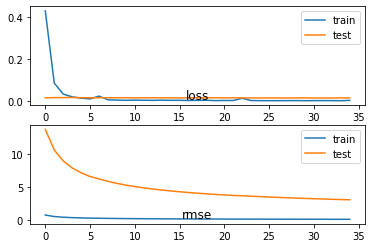

In [0]:
plot_history(model_history[0])

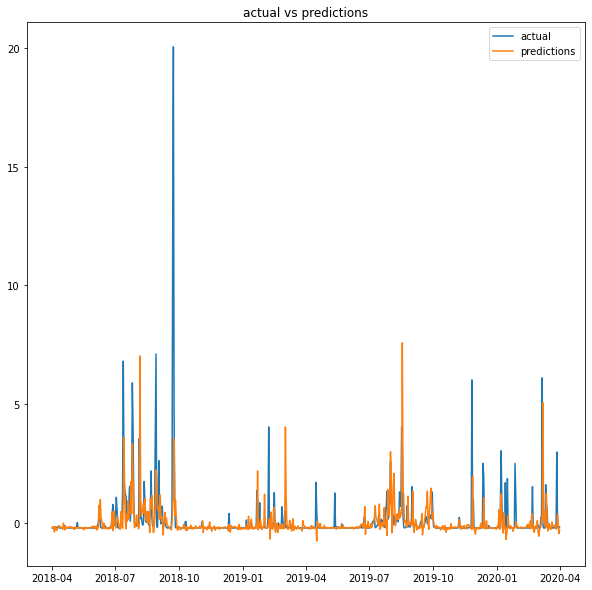

In [0]:
predictions = np.reshape(np.array(predictions),(730,1))
indices = dataset.index.tolist()[-730:]
test = pd.DataFrame(test,index = indices)
predictions = pd.DataFrame(predictions,index = indices)
fig = plt.figure(figsize=(10,10))
plt.plot(test[0],label = 'actual')
plt.plot(predictions[0],label = 'predictions')
plt.title('actual vs predictions')
plt.legend()

In [0]:
indices = dataset.index.tolist()[-730:]
df_predict = pd.DataFrame(scaler.inverse_transform(predictions),index= indices, columns=['Prediction'])
df_test = pd.concat([dataset,df_predict], axis=1)
df_test.head()

In [0]:
plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['Rainfall'])
plt.plot(df_test.index, df_test['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

# learning rate,optimisers,ENSEMBELINGscaling,(rmse,mape)metrics,dropout,recurrent dropout,batch size,epochs,n_input,n_diff,filters,kernel_size,layers(lstm,bi-lstm,convlstm,cnn-lstm,multichannel,multiheaded),steps_per_epoch,valid_steps,view_metrics(model.fit)

In [0]:
print(scores)

[7.891412676324647]


In [0]:
model_history.history.keys()

dict_keys(['loss', 'root_mean_squared_error'])

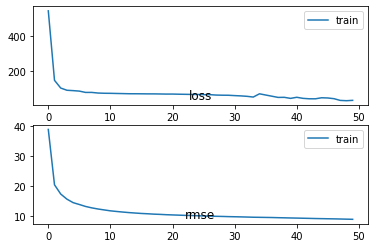

In [0]:
plot_history(model_history)

In [0]:
test[:,0].shape

(1480,)

In [0]:
indices = dataset.index.tolist()[-1480:]
len(indices)

1480

In [0]:
len(predictions)

1480

In [0]:
test = pd.DataFrame(test,index = indices)
test.head()

,0,1,2,3,4,5,6
2016-03-13,7.140871,291.69,63.99,934.22,2.16,148.98,3749.760
2016-03-14,1.057122,290.88,51.81,936.85,0.70,293.25,5030.944
2016-03-15,0.022767,291.36,40.39,936.19,3.35,295.09,5885.960
2016-03-16,0.000016,293.02,33.43,933.53,3.31,292.39,6528.071
2016-03-17,2.620737,293.50,43.67,934.55,0.95,81.60,4469.213


In [0]:
predictions = pd.DataFrame(predictions,index = indices)
predictions.head()

,0
2016-03-13,2.854148
2016-03-14,4.530697
2016-03-15,1.958427
2016-03-16,0.908319
2016-03-17,0.907800


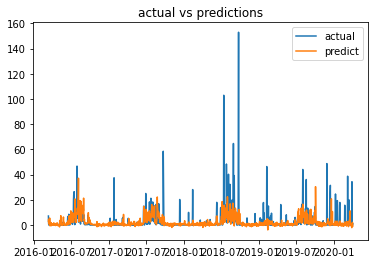

In [0]:
plt.plot(test[0],label = 'actual')
plt.plot(predictions,label = 'predict')
plt.title('actual vs predictions')
plt.legend()
plt.show()

# mutli-channel cnn

In [0]:
# split a univariate dataset into train/test sets
def split_dataset(data):
  train, test= data[:-730], data[-730:]
  return train,test

# evaluate forecasts against expected values
def evaluate_forecasts(actual, predicted):
  scores = list()
  mse = mean_squared_error(actual, predicted)
  # calculate rmse
  rmse = sqrt(mse)
  # store
  scores.append(rmse)
  return scores

# summarize scores
#def summarize_scores(name, score, scores):
 # s_scores = ', '.join(['%.1f' % s for s in scores])
  #print('%s: [%.3f] %s' % (name, score, s_scores))
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=1):
  # flatten data
  data = train.copy()
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for _ in range(len(data)):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    # ensure we have enough data for this instance
    if out_end <= len(data):
      X.append(data[in_start:in_end, :])
      y.append(data[in_end:out_end, 0])
    # move along one time step
    in_start += 1
  return array(X), array(y)
# plot training history
def plot_history(history):
  # plot loss
  pyplot.subplot(2, 1, 1)
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.title('loss', y=0, loc='center')
  pyplot.legend()
  # plot rmse
  pyplot.subplot(2, 1, 2)
  pyplot.plot(history.history['root_mean_squared_error'], label='train')
  pyplot.plot(history.history['val_rmse'], label='test')
  pyplot.title('rmse', y=0, loc='center')
  pyplot.legend()
  pyplot.show()
# train the model
def build_model(train,cfg):
  # prepare data
  n_input,n_filters,n_kernels,n_epochs,n_batch,n_diff = cfg
  train_x, train_y = to_supervised(train, n_input)
  train_x,valid_x,train_y,valid_y = train_test_split(train_x,train_y,test_size = 0.1,shuffle = False)
  # define parameters
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  # create a channel for each variable
  model = Sequential()
  model.add(Conv1D(32, 3, activation='relu', input_shape=(n_timesteps,n_features)))
  model.add(Conv1D(32, 3, activation='relu'))
  model.add(MaxPooling1D())
  model.add(Conv1D(16, 3, activation='relu'))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs))

  # compile model
  model.compile(loss='mse', optimizer='adam',metrics=[tf.keras.metrics.RootMeanSquaredError()])
  # plot the model
  plot_model(model, show_shapes=True, to_file='multiheaded_cnn.png')
  # fit network
  model_history = model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, validation_data = (valid_x,valid_y),verbose=0)
  return model,model_history

# make a forecast
def forecast(model, history, cfg):
  # flatten data
  data = array(history)
  # retrieve last observations for input data
  n_input,_,_,_,_,_ = cfg
  input_x = data[-n_input:, :]
  # reshape into n input arrays
  input_x = [input_x[:,i].reshape((1,input_x.shape[0],1)) for i in range(input_x.shape[1])]
  # forecast the next day
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat[0]
  return yhat

# evaluate a single model
def evaluate_model(train,test, cfg):
  # fit model
  model,model_history = build_model(train,cfg)
  # history is a list of train data
  history = [x for x in train]
  # walk-forward validation over each day
  predictions = list()
  for i in range(len(test)):
    # predict the day
    yhat_sequence = forecast(model, history,cfg)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next day
    history.append(test[i, :])
  # evaluate predictions for each day
  predictions = array(predictions)
  scores = evaluate_forecasts(test[:,0], predictions)
  return scores,model_history,predictions
# score a model, return None on failure
def repeat_evaluate(train,test,cfg,n_repeats=1):
  # convert config to a key
  key = str(cfg)
  # fit and evaluate the model n times
  result = []
  for i in range(n_repeats):
    if i == (n_repeats-1):
      scores,model_history,predictions = evaluate_model(train,test,cfg) 
      result.append(scores)
    else:
      scores,_,_ = evaluate_model(train,test,cfg) 
      result.append(scores)
  # summarize score
  result = mean(result)
  print('> Model[%s] %.3f' % (key, result))
  return (result)
  # grid search configs
def grid_search(train,test, cfg_list):
  # evaluate configs
  scores =  [repeat_evaluate(train,test, cfg) for cfg in cfg_list]
  # sort configs by error, asc
  scores.sort(key=lambda tup: tup[1])
  return scores

# Vanilla LSTM

In [0]:
# split a univariate dataset into train/test sets
def split_dataset(data):
  train, test= data[:-730], data[-730:]
  return train,test

# evaluate forecasts against expected values
def evaluate_forecasts(actual, predicted):
  scores = list()
  mse = mean_squared_error(actual, predicted)
  # calculate rmse
  rmse = sqrt(mse)
  # store
  scores.append(rmse)
  return scores

# summarize scores
#def summarize_scores(name, score, scores):
 # s_scores = ', '.join(['%.1f' % s for s in scores])
  #print('%s: [%.3f] %s' % (name, score, s_scores))
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=1):
  # flatten data
  data = train.copy()
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for _ in range(len(data)):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    # ensure we have enough data for this instance
    if out_end <= len(data):
      X.append(data[in_start:in_end, :])
      y.append(data[in_end:out_end, 0])
    # move along one time step
    in_start += 1
  return array(X), array(y)
# plot training history
def plot_history(history):
  # plot loss
  pyplot.subplot(2, 1, 1)
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.title('loss', y=0, loc='center')
  pyplot.legend()
  # plot rmse
  pyplot.subplot(2, 1, 2)
  pyplot.plot(history.history['root_mean_squared_error'], label='train')
  pyplot.plot(history.history['val_rmse'], label='test')
  pyplot.title('rmse', y=0, loc='center')
  pyplot.legend()
  pyplot.show()
# train the model
def build_model(train,cfg):
  # prepare data
  n_input,n_filters,n_kernels,n_epochs,n_batch,n_diff = cfg
  train_x, train_y = to_supervised(train, n_input)
  train_x,valid_x,train_y,valid_y = train_test_split(train_x,train_y,test_size = 0.1,shuffle = False)
  # define parameters
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  # create a channel for each variable
  model = Sequential()
  model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
  model.add(Dense(100, activation='relu'))

  # compile model
  model.compile(loss='mse', optimizer='adam',metrics=[tf.keras.metrics.RootMeanSquaredError()])
  # plot the model
  plot_model(model, show_shapes=True, to_file='multiheaded_cnn.png')
  # fit network
  model_history = model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, validation_data = (valid_x,valid_y),verbose=0)
  return model,model_history

# make a forecast
def forecast(model, history, cfg):
  # flatten data
  data = array(history)
  # retrieve last observations for input data
  n_input,_,_,_,_,_ = cfg
  input_x = data[-n_input:, :]
  # reshape into [1, n_input, n]
  input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))

  # forecast the next day
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat[0]
  return yhat

# evaluate a single model
def evaluate_model(train,test, cfg):
  # fit model
  model,model_history = build_model(train,cfg)
  # history is a list of train data
  history = [x for x in train]
  # walk-forward validation over each day
  predictions = list()
  for i in range(len(test)):
    # predict the day
    yhat_sequence = forecast(model, history,cfg)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next day
    history.append(test[i, :])
  # evaluate predictions for each day
  predictions = array(predictions)
  scores = evaluate_forecasts(test[:,0], predictions)
  return scores,model_history,predictions
# score a model, return None on failure
def repeat_evaluate(train,test,cfg,n_repeats=1):
  # convert config to a key
  key = str(cfg)
  # fit and evaluate the model n times
  result = []
  for i in range(n_repeats):
    if i == (n_repeats-1):
      scores,model_history,predictions = evaluate_model(train,test,cfg) 
      result.append(scores)
    else:
      scores,_,_ = evaluate_model(train,test,cfg) 
      result.append(scores)
  # summarize score
  result = mean(result)
  print('> Model[%s] %.3f' % (key, result))
  return (result)
  # grid search configs
def grid_search(train,test, cfg_list):
  # evaluate configs
  scores =  [repeat_evaluate(train,test, cfg) for cfg in cfg_list]
  # sort configs by error, asc
  scores.sort(key=lambda tup: tup[1])
  return scores

# encoder-decoder LSTM

In [0]:
# split a univariate dataset into train/test sets
def split_dataset(data):
  train, test= data[:-730], data[-730:]
  return train,test

# evaluate forecasts against expected values
def evaluate_forecasts(actual, predicted):
  scores = list()
  mse = mean_squared_error(actual, predicted)
  # calculate rmse
  rmse = sqrt(mse)
  # store
  scores.append(rmse)
  return scores

# summarize scores
#def summarize_scores(name, score, scores):
 # s_scores = ', '.join(['%.1f' % s for s in scores])
  #print('%s: [%.3f] %s' % (name, score, s_scores))
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=1):
  # flatten data
  data = train.copy()
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for _ in range(len(data)):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    # ensure we have enough data for this instance
    if out_end <= len(data):
      X.append(data[in_start:in_end, :])
      y.append(data[in_end:out_end, 0])
    # move along one time step
    in_start += 1
  return array(X), array(y)
# plot training history
def plot_history(history):
  # plot loss
  pyplot.subplot(2, 1, 1)
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.title('loss', y=0, loc='center')
  pyplot.legend()
  # plot rmse
  pyplot.subplot(2, 1, 2)
  pyplot.plot(history.history['root_mean_squared_error'], label='train')
  pyplot.plot(history.history['val_rmse'], label='test')
  pyplot.title('rmse', y=0, loc='center')
  pyplot.legend()
  pyplot.show()
# train the model
def build_model(train,cfg):
  # prepare data
  n_input,n_filters,n_kernels,n_epochs,n_batch,n_diff = cfg
  train_x, train_y = to_supervised(train, n_input)
  train_x,valid_x,train_y,valid_y = train_test_split(train_x,train_y,test_size = 0.1,shuffle = False)
  # define parameters
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  # create a channel for each variable
  train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
  valid_y = valid_y.reshape((valid_y.shape[0], valid_y.shape[1], 1))
  # define model
  model = Sequential()
  model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
  model.add(RepeatVector(n_outputs))
  model.add(LSTM(200, activation='relu', return_sequences=True))
  model.add(TimeDistributed(Dense(100, activation='relu')))
  model.add(TimeDistributed(Dense(1)))


  # compile model
  model.compile(loss='mse', optimizer='adam',metrics=[tf.keras.metrics.RootMeanSquaredError()])
  # plot the model
  plot_model(model, show_shapes=True, to_file='multiheaded_cnn.png')
  # fit network
  model_history = model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, validation_data = (valid_x,valid_y),verbose=0)
  return model,model_history

# make a forecast
def forecast(model, history, cfg):
  # flatten data
  data = array(history)
  # retrieve last observations for input data
  n_input,_,_,_,_,_ = cfg
  input_x = data[-n_input:, :]
  # reshape into [1, n_input, n]
  input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))

  # forecast the next day
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat[0]
  return yhat

# evaluate a single model
def evaluate_model(train,test, cfg):
  # fit model
  model,model_history = build_model(train,cfg)
  # history is a list of train data
  history = [x for x in train]
  # walk-forward validation over each day
  predictions = list()
  for i in range(len(test)):
    # predict the day
    yhat_sequence = forecast(model, history,cfg)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next day
    history.append(test[i, :])
  # evaluate predictions for each day
  predictions = array(predictions)
  scores = evaluate_forecasts(test[:,0], predictions)
  return scores,model_history,predictions
# score a model, return None on failure
def repeat_evaluate(train,test,cfg,n_repeats=1):
  # convert config to a key
  key = str(cfg)
  # fit and evaluate the model n times
  result = []
  for i in range(n_repeats):
    if i == (n_repeats-1):
      scores,model_history,predictions = evaluate_model(train,test,cfg) 
      result.append(scores)
    else:
      scores,_,_ = evaluate_model(train,test,cfg) 
      result.append(scores)
  # summarize score
  result = mean(result)
  print('> Model[%s] %.3f' % (key, result))
  return (result)
  # grid search configs
def grid_search(train,test, cfg_list):
  # evaluate configs
  scores =  [repeat_evaluate(train,test, cfg) for cfg in cfg_list]
  # sort configs by error, asc
  scores.sort(key=lambda tup: tup[1])
  return scores

# CNN LSTM ENCODER DECODER

In [0]:
# split a univariate dataset into train/test sets
def split_dataset(data):
  train, test= data[:-730], data[-730:]
  return train,test

# evaluate forecasts against expected values
def evaluate_forecasts(actual, predicted):
  scores = list()
  mse = mean_squared_error(actual, predicted)
  # calculate rmse
  rmse = sqrt(mse)
  # store
  scores.append(rmse)
  return scores

# summarize scores
#def summarize_scores(name, score, scores):
 # s_scores = ', '.join(['%.1f' % s for s in scores])
  #print('%s: [%.3f] %s' % (name, score, s_scores))
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=1):
  # flatten data
  data = train.copy()
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for _ in range(len(data)):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    # ensure we have enough data for this instance
    if out_end <= len(data):
      X.append(data[in_start:in_end, :])
      y.append(data[in_end:out_end, 0])
    # move along one time step
    in_start += 1
  return array(X), array(y)
# plot training history
def plot_history(history):
  # plot loss
  pyplot.subplot(2, 1, 1)
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.title('loss', y=0, loc='center')
  pyplot.legend()
  # plot rmse
  pyplot.subplot(2, 1, 2)
  pyplot.plot(history.history['root_mean_squared_error'], label='train')
  pyplot.plot(history.history['val_rmse'], label='test')
  pyplot.title('rmse', y=0, loc='center')
  pyplot.legend()
  pyplot.show()
# train the model
def build_model(train,cfg):
  # prepare data
  n_input,n_filters,n_kernels,n_epochs,n_batch,n_diff = cfg
  train_x, train_y = to_supervised(train, n_input)
  train_x,valid_x,train_y,valid_y = train_test_split(train_x,train_y,test_size = 0.1,shuffle = False)
  # define parameters
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  # create a channel for each variable
  train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
  valid_y = valid_y.reshape((valid_y.shape[0], valid_y.shape[1], 1))
  # define model
  model = Sequential()
  model.add(Conv1D(64, 3, activation='relu', input_shape=(n_timesteps,n_features)))
  model.add(Conv1D(64, 3, activation='relu'))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(RepeatVector(n_outputs))
  model.add(LSTM(200, activation='relu', return_sequences=True))
  model.add(TimeDistributed(Dense(100, activation='relu')))
  model.add(TimeDistributed(Dense(1)))

  # compile model
  model.compile(loss='mse', optimizer='adam',metrics=[tf.keras.metrics.RootMeanSquaredError()])
  # plot the model
  plot_model(model, show_shapes=True, to_file='multiheaded_cnn.png')
  # fit network
  model_history = model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, validation_data = (valid_x,valid_y),verbose=0)
  return model,model_history

# make a forecast
def forecast(model, history, cfg):
  # flatten data
  data = array(history)
  # retrieve last observations for input data
  n_input,_,_,_,_,_ = cfg
  input_x = data[-n_input:, :]
  # reshape into [1, n_input, n]
  input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))

  # forecast the next day
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat[0]
  return yhat

# evaluate a single model
def evaluate_model(train,test, cfg):
  # fit model
  model,model_history = build_model(train,cfg)
  # history is a list of train data
  history = [x for x in train]
  # walk-forward validation over each day
  predictions = list()
  for i in range(len(test)):
    # predict the day
    yhat_sequence = forecast(model, history,cfg)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next day
    history.append(test[i, :])
  # evaluate predictions for each day
  predictions = array(predictions)
  scores = evaluate_forecasts(test[:,0], predictions)
  return scores,model_history,predictions
# score a model, return None on failure
def repeat_evaluate(train,test,cfg,n_repeats=1):
  # convert config to a key
  key = str(cfg)
  # fit and evaluate the model n times
  result = []
  for i in range(n_repeats):
    if i == (n_repeats-1):
      scores,model_history,predictions = evaluate_model(train,test,cfg) 
      result.append(scores)
    else:
      scores,_,_ = evaluate_model(train,test,cfg) 
      result.append(scores)
  # summarize score
  result = mean(result)
  print('> Model[%s] %.3f' % (key, result))
  return (result)
  # grid search configs
def grid_search(train,test, cfg_list):
  # evaluate configs
  scores =  [repeat_evaluate(train,test, cfg) for cfg in cfg_list]
  # sort configs by error, asc
  scores.sort(key=lambda tup: tup[1])
  return scores

# CONVLSTM encoder-decoder

In [0]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
  scores = list()
  # calculate an RMSE score for each day
  # calculate mse
  mse = mean_squared_error(actual, predicted)
  # calculate rmse
  rmse = sqrt(mse)
  # store
  scores.append(rmse)
  # calculate overall RMSE
  #s = 0
  #for row in range(actual.shape[0]):
  #for col in range(actual.shape[1]):
  #s += (actual[row, col] - predicted[row, col])**2
  #score = sqrt(s / (actual.shape[0] * actual.shape[1]))
  return scores

# summarize scores
def summarize_scores(name, score, scores):
  s_scores = ', '.join(['%.1f' % s for s in scores])
  print('%s: [%.3f] %s' % (name, score, s_scores))
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=1):
  # flatten data
  data = train.copy()
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for _ in range(len(data)):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    # ensure we have enough data for this instance
    if out_end <= len(data):
      X.append(data[in_start:in_end, :])
      y.append(data[in_end:out_end, 0])
    # move along one time step
    in_start += 1
  return array(X), array(y)
# train the model
def build_model(train, n_input):
  # prepare data
  train_x, train_y = to_supervised(train, n_input)
  # define parameters
  verbose, epochs, batch_size = 0, 100, 8
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

  train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
  valid_y = valid_y.reshape((valid_y.shape[0], valid_y.shape[1], 1))
  # define model
  model = Sequential()
  model.add(Conv1D(64, 3, activation='relu', input_shape=(n_timesteps,n_features)))
  model.add(Conv1D(64, 3, activation='relu'))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(RepeatVector(n_outputs))
  model.add(LSTM(200, activation='relu', return_sequences=True))
  model.add(TimeDistributed(Dense(100, activation='relu')))
  model.add(TimeDistributed(Dense(1)))

  model.compile(loss='mse', optimizer='adam',metrics = ['accuracy'])
  # fit network
  model_history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
  return model,model_history
# make a forecast
def forecast(model, history, n_input):
  # flatten data
  data = array(history)
  #data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  # retrieve last observations for input data
  input_x = data[-n_input:, :]
  # reshape into [1, n_input, n]
  input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
  # forecast the next week
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat[0]
  return yhat
# evaluate a single model
def evaluate_model(train, test, n_input):
  # fit model
  model,model_history = build_model(train, n_input)
  # history is a list of weekly data
  history = [x for x in train]
  # walk-forward validation over each week
  predictions = list()
  for i in range(len(test)):
    # predict the week
    yhat_sequence = forecast(model, history, n_input)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
  # evaluate predictions days for each week
  predictions = array(predictions)
  scores = evaluate_forecasts(test[:,0], predictions)
  return scores,model_history

In [0]:
# split a univariate dataset into train/test sets
def split_dataset(data):
  train, test= data[:-730], data[-730:]
  return train,test

# evaluate forecasts against expected values
def evaluate_forecasts(actual, predicted):
  scores = list()
  mse = mean_squared_error(actual, predicted)
  # calculate rmse
  rmse = sqrt(mse)
  # store
  scores.append(rmse)
  return scores

# summarize scores
#def summarize_scores(name, score, scores):
 # s_scores = ', '.join(['%.1f' % s for s in scores])
  #print('%s: [%.3f] %s' % (name, score, s_scores))
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=1):
  # flatten data
  data = train.copy()
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for _ in range(len(data)):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    # ensure we have enough data for this instance
    if out_end <= len(data):
      X.append(data[in_start:in_end, :])
      y.append(data[in_end:out_end, 0])
    # move along one time step
    in_start += 1
  return array(X), array(y)
# plot training history
def plot_history(history):
  # plot loss
  pyplot.subplot(2, 1, 1)
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.title('loss', y=0, loc='center')
  pyplot.legend()
  # plot rmse
  pyplot.subplot(2, 1, 2)
  pyplot.plot(history.history['root_mean_squared_error'], label='train')
  pyplot.plot(history.history['val_rmse'], label='test')
  pyplot.title('rmse', y=0, loc='center')
  pyplot.legend()
  pyplot.show()
# train the model
def build_model(train,cfg):
  # prepare data
  n_input,n_filters,n_kernels,n_epochs,n_batch,n_diff = cfg
  train_x, train_y = to_supervised(train, n_input)
  train_x,valid_x,train_y,valid_y = train_test_split(train_x,train_y,test_size = 0.1,shuffle = False)
  # define parameters
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  # reshape into subsequences [samples, timesteps, rows, cols, channels]
  train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
  valid_x = valid_x.reshape((valid_x.shape[0], n_steps, 1, n_length, n_features)) 
  # create a channel for each variable
  train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
  valid_y = valid_y.reshape((valid_y.shape[0], valid_y.shape[1], 1))
  # define model
  model = Sequential()
  model.add(ConvLSTM2D(64, (1,3), activation='relu', input_shape=(n_steps, 1, n_length,
  n_features)))
  model.add(Flatten())
  model.add(RepeatVector(n_outputs))
  model.add(LSTM(200, activation='relu', return_sequences=True))
  model.add(TimeDistributed(Dense(100, activation='relu')))
  model.add(TimeDistributed(Dense(1)))
  # compile model
  model.compile(loss='mse', optimizer='adam',metrics=[tf.keras.metrics.RootMeanSquaredError()])
  # plot the model
  plot_model(model, show_shapes=True, to_file='multiheaded_cnn.png')
  # fit network
  model_history = model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, validation_data = (valid_x,valid_y),verbose=0)
  return model,model_history

# make a forecast
def forecast(model, history, cfg):
  # flatten data
  data = array(history)
  # retrieve last observations for input data
  n_input,_,_,_,_,_ = cfg
  input_x = data[-n_input:, :]
  # reshape into [1, n_input, n]
  input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))

  # forecast the next day
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat[0]
  return yhat

# evaluate a single model
def evaluate_model(train,test, cfg):
  # fit model
  model,model_history = build_model(train,cfg)
  # history is a list of train data
  history = [x for x in train]
  # walk-forward validation over each day
  predictions = list()
  for i in range(len(test)):
    # predict the day
    yhat_sequence = forecast(model, history,cfg)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next day
    history.append(test[i, :])
  # evaluate predictions for each day
  predictions = array(predictions)
  scores = evaluate_forecasts(test[:,0], predictions)
  return scores,model_history,predictions
# score a model, return None on failure
def repeat_evaluate(train,test,cfg,n_repeats=1):
  # convert config to a key
  key = str(cfg)
  # fit and evaluate the model n times
  result = []
  for i in range(n_repeats):
    if i == (n_repeats-1):
      scores,model_history,predictions = evaluate_model(train,test,cfg) 
      result.append(scores)
    else:
      scores,_,_ = evaluate_model(train,test,cfg) 
      result.append(scores)
  # summarize score
  result = mean(result)
  print('> Model[%s] %.3f' % (key, result))
  return (result)
  # grid search configs
def grid_search(train,test, cfg_list):
  # evaluate configs
  scores =  [repeat_evaluate(train,test, cfg) for cfg in cfg_list]
  # sort configs by error, asc
  scores.sort(key=lambda tup: tup[1])
  return scores

In [0]:
# load the new file
#dataset = read_csv('household_power_consumption_days.csv', header=0,
#infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 7
scores,model_history = evaluate_model(train, test, n_input)
# summarize scores
#summarize_scores('cnn', score, scores)
# plot scores
#days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
#pyplot.plot(days, scores, marker='o', label='cnn')
#pyplot.show()

KeyboardInterrupt: ignored

In [0]:
print(scores)

[7.022464081640758]


In [0]:
model_history.history

{'accuracy': [0.015223275,
  0.016576454,
  0.025541272,
  0.031968877,
  0.033998646,
  0.04397835,
  0.049052775,
  0.061907984,
  0.07222598,
  0.086772665,
  0.11654262,
  0.113667116,
  0.1085927,
  0.1517253,
  0.1549391,
  0.1588295,
  0.17642084,
  0.14766577,
  0.14292963,
  0.14715832,
  0.15612315,
  0.15392423,
  0.14343707,
  0.18098782,
  0.16339648,
  0.1791272,
  0.19130582,
  0.19367388,
  0.17675914,
  0.18183357,
  0.19638024,
  0.16474967,
  0.16238159,
  0.13717861,
  0.16830176,
  0.16508795,
  0.17608254,
  0.15832205,
  0.16948579,
  0.16305819,
  0.1556157,
  0.18014209,
  0.14191476,
  0.116035186,
  0.1520636,
  0.13768606,
  0.13717861,
  0.17185386,
  0.13667117,
  0.14309879,
  0.17845061,
  0.14377537,
  0.11332882,
  0.11231394,
  0.16491881,
  0.13125846,
  0.17253044,
  0.15899865,
  0.1655954,
  0.1688092,
  0.15071042,
  0.15730718,
  0.14106901,
  0.17574425,
  0.14343707,
  0.15950608,
  0.16407306,
  0.15967524,
  0.17219216,
  0.13616374],
 'loss

In [0]:
data = df.copy()

In [0]:
data = data.drop(['Snowfall','Snow depth'],axis=1)

In [0]:
data.head(5)

,# Date,UT time,Temperature,Relative Humidity,Pressure,Wind speed,Wind direction,Rainfall,Short-wave irradiation
0,2000-01-01,24:00,286.69,20.42,938.00,0.34,359.45,0.0,4057.961
1,2000-01-02,24:00,286.54,20.20,937.75,0.19,359.78,0.0,4090.309
2,2000-01-03,24:00,286.15,19.93,936.07,0.23,328.13,0.0,4117.362
3,2000-01-04,24:00,286.06,20.16,936.70,0.38,301.85,0.0,4137.729
4,2000-01-05,24:00,285.80,19.69,937.07,1.47,307.53,0.0,4169.898


In [0]:
data = data.rename(columns={'# Date':'Date'})

In [0]:
data.head(1)

,Date,UT time,Temperature,Relative Humidity,Pressure,Wind speed,Wind direction,Rainfall,Short-wave irradiation
0,2000-01-01,24:00,286.69,20.42,938.0,0.34,359.45,0.0,4057.961


In [0]:
data['Date'] = data[['Date', 'UT time']].apply(lambda x: ' '.join(x), axis=1)

In [0]:
data.head(1)

,Date,UT time,Temperature,Relative Humidity,Pressure,Wind speed,Wind direction,Rainfall,Short-wave irradiation
0,2000-01-01 24:00,24:00,286.69,20.42,938.0,0.34,359.45,0.0,4057.961


In [0]:
data = data.drop(columns={'UT time'})

In [0]:
data.head(1)

,Date,Temperature,Relative Humidity,Pressure,Wind speed,Wind direction,Rainfall,Short-wave irradiation
0,2000-01-01 24:00,286.69,20.42,938.0,0.34,359.45,0.0,4057.961


In [0]:
s = data['Date'].str.split()
data['Date'] = pd.to_datetime(s.str[0]) + pd.to_timedelta(s.str[1].str.split(':').str[0] +' hours')
print(data)

           Date  Temperature  ...   Rainfall  Short-wave irradiation
0    2000-01-02       286.69  ...   0.000000                4057.961
1    2000-01-03       286.54  ...   0.000000                4090.309
2    2000-01-04       286.15  ...   0.000000                4117.362
3    2000-01-05       286.06  ...   0.000000                4137.729
4    2000-01-06       285.80  ...   0.000000                4169.898
...         ...          ...  ...        ...                     ...
7391 2020-03-28       289.98  ...  34.353204                2492.437
7392 2020-03-29       291.25  ...   0.723719                6809.119
7393 2020-03-30       291.75  ...   0.009665                7123.750
7394 2020-03-31       291.72  ...   0.000000                5194.482
7395 2020-04-01       293.63  ...   1.063542                5431.916

[7396 rows x 8 columns]


In [0]:
data = data.rename(columns={'Short-wave irradiation':'SWI','Wind speed':'Wspeed','Wind direction':'Wdirect'})

In [0]:
data = data.set_index('Date',drop=True)
data.index.name = 'Date'

In [0]:
data.head(1)

,Temperature,Relative Humidity,Pressure,Wspeed,Wdirect,Rainfall,SWI
Date,,,,,,,
2000-01-02,286.69,20.42,938.0,0.34,359.45,0.0,4057.961


In [0]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[:-1480], data[-1480:]
	# restructure into windows of weekly data
	#train = array(split(train, len(train)/7))
	#test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	#for i in range(actual.shape[1]):
		# calculate mse
	mse = mean_squared_error(actual, predicted)
		# calculate rmse
	rmse = sqrt(mse)
		# store
	scores.append(rmse)
	# calculate overall RMSE
	#s = 0
	#for row in range(actual.shape[0]):
	#	for col in range(actual.shape[1]):
	#		s += (actual[row, col] - predicted[row, col])**2
  #score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=1):
	# flatten data
	#data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 100, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam',metrics = ['accuracy'])
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

In [0]:
s = [((1,2),3,4),((2,3),5,6)]

In [0]:
s[1][0]

(2, 3)

In [0]:
l= []
m = []
n = []
for i in range(len(s)):
  l.append(s[i][0])
  m.append(s[i][1])
  n.append(s[i][2])
print(l) 
print(m) 
print(n)  

[(1, 2), (2, 3)]
[3, 5]
[4, 6]


In [0]:
s = [(1,7),(3,4)]

In [0]:
l.sort(key=lambda tup: tup[1])

In [0]:
for cfg, error in l:
  print(cfg, error)

1 2
2 3


In [0]:
float_data = dataset.values

In [0]:
float_data.shape

(14701, 7)

In [0]:
mean = float_data[:13241].mean(axis=0)
float_data -= mean

std = float_data[:13241].std(axis=0)
float_data /= std

In [0]:

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=64, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [0]:

lookback = 3
step = 1
delay = 1
batch_size = 32

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=13241,
                      shuffle=False,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=13242,
                    max_index=13971,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=13972,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (13971 - 13242 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 13972 - lookback) // batch_size

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(LSTM(200,dropout= 0.1,recurrent_dropout= 0.1, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanAbsolutePercentageError()])
model.summary()
loss_history_1 = model.fit_generator(train_gen,
                                          steps_per_epoch=413,
                                          epochs=100,
                                          validation_data=val_gen,
                                          validation_steps=val_steps)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 200)               166400    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 186,601
Trainable params: 186,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
413/413 [==============================] - 4s 11ms/step - loss: 0.1199 - root_mean_squared_error: 0.4443 - mean_absolute_percentage_error: 106.1110 - val_loss: 0.0572 - val_root_mean_squared_error: 0.3446 - val_mean_absolute_percentage_error: 91.9434
Epoch 2/100
413/413 [==============================] - 4s 10ms/step - loss: 0.0761 - root_mean_squared_error: 0.325

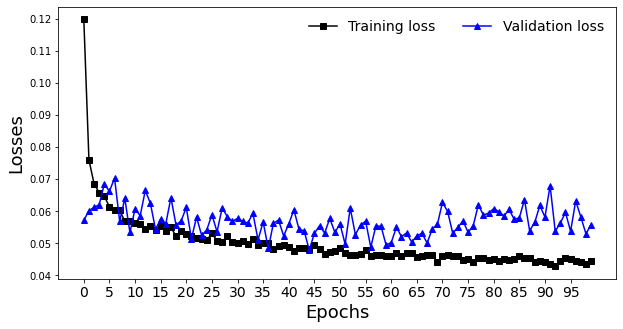

In [0]:
axis_font = {'family':'arial', 'style':'normal', 'size':18}
ts_tra_loss = loss_history_1.history['loss']
ts_val_loss = loss_history_1.history['val_loss']

ts_in_epochs = np.arange(0, len(ts_tra_loss))
fig = plt.figure(figsize=(10, 5))

plt.plot(ts_in_epochs, ts_tra_loss, 's-', color="k", label='Training loss')
plt.plot(ts_in_epochs, ts_val_loss, '^-', color="b", label='Validation loss')

ts_xlabels = np.arange(0, len(ts_in_epochs), 5)
plt.xticks(ts_xlabels, ts_xlabels, fontsize=14)

plt.xlabel("Epochs", axis_font)
plt.ylabel("Losses", axis_font)
plt.legend(ncol=2, frameon=False, fontsize=14)

plt.show()

In [0]:

fo_model = model.evaluate_generator(test_gen, test_steps)
print("INFO: LSTM: %5.3f" %fo_model[0])

INFO: LSTM: 0.058


In [0]:
fo_model

[0.058348752558231354, 0.2239987850189209, 64.89913177490234]

In [0]:
predictions = model.predict(test_gen,verbose = 0,steps=  test_steps)

In [0]:
len(predictions)

704

In [0]:
transformed_dataset = pd.DataFrame(float_data)

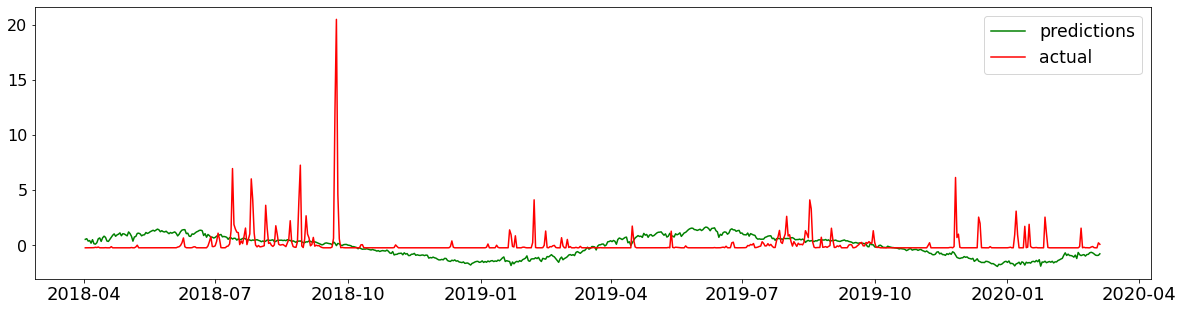

In [0]:
plt.figure(figsize = (20,5))
plt.plot(dataset.index[-730:-26],predictions,label = 'predictions',color = 'g')
plt.plot(dataset.index[-730:-26],transformed_dataset[13971:-26][0],label = 'actual',color=  'r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [0]:
def actual(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=64, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        return samples,targets

In [0]:
test_targets = actual(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=13972,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [0]:
test_targets[0]

array([[[-0.21851011,  0.4131578 , -0.69616683,  0.13580625,
         -1.19475249, -1.65998418, -1.288602  ],
        [-0.21863338,  0.66431969, -0.89539159, -0.31450647,
         -0.31537446,  0.88465961,  0.31641876],
        [-0.21756246,  0.80687104, -0.80684725, -0.46259589,
         -0.5776451 ,  0.94305625,  0.37364014]],

       [[-0.21863338,  0.66431969, -0.89539159, -0.31450647,
         -0.31537446,  0.88465961,  0.31641876],
        [-0.21756246,  0.80687104, -0.80684725, -0.46259589,
         -0.5776451 ,  0.94305625,  0.37364014],
        [-0.2179892 ,  0.77157261, -0.87229307, -0.14677254,
         -0.07624534,  0.67343121,  0.17401792]],

       [[-0.21756246,  0.80687104, -0.80684725, -0.46259589,
         -0.5776451 ,  0.94305625,  0.37364014],
        [-0.2179892 ,  0.77157261, -0.87229307, -0.14677254,
         -0.07624534,  0.67343121,  0.17401792],
        [-0.20987922,  0.55706678, -0.52774011,  0.21589542,
         -0.45422362, -1.08980021,  0.32888166]],

    

In [0]:
float_data = dataset.values

In [0]:
type(float_data)

numpy.ndarray

In [0]:

mean = float_data[:13241].mean(axis=0)
float_data -= mean

std = float_data[:13241].std(axis=0)
float_data /= std

In [0]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=64, step=1):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for _ in range(len(data)):
    # define the end of the input sequence
    in_end = in_start + lookback
    out_end = in_end + delay
    # ensure we have enough data for this instance
    if out_end <= len(data):
      X.append(data[in_start:in_end, :])
      y.append(data[in_end:out_end, 0])
      # move along one time step
      in_start += 1
  X,y =  array(X), array(y)  
  while 1:

        # if shuffle:
        #     rows = np.random.randint(
        #         min_index + lookback, max_index, size=batch_size)
        # else:
        #     if i + batch_size >= max_index:
        #         i = min_index + lookback
        #     rows = np.arange(i, min(i + batch_size, max_index))
        #     i += len(rows)
        n_batches = len(X)//batch_size + 1
        remainder = len(X)%(batch_size)
       
        for j in range(n_batches+1):
            indices = range(j*batch_size,(j+1)*batch_size)
            if j==(n_batches):
              samples[j] = X[-remainder:]
              targets[j] = y[-remainder:]
            samples[j] = X[indices]
            targets[j] =  y[indices]
        return samples, targets

In [0]:
train_targets = generator(float_data,
                     lookback=3,
                     delay=1,
                     min_index=0,
                     max_index=13241,
                     )

ValueError: ignored

In [0]:
lookback = 3
step = 1
delay = 1
batch_size = 32

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=13241,
                      shuffle=False,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=13242,
                    max_index=13971,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=13972,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (13971 - 13242 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 13972 - lookback) // batch_size

In [0]:
test_targets[0].shape

(32, 3, 7)

In [0]:
 kbfekbf
  fkk,jefnjbkjbf
  jbfkhskhf